In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
cd "/Users/m/Desktop/ADS/Data Mining I/Project/Mens Tournament"

/Users/m/Desktop/ADS/Data Mining I/Project/Mens Tournament


In [3]:
pwd

'/Users/m/Desktop/ADS/Data Mining I/Project/Mens Tournament'

In [4]:
df_seeds = pd.read_csv ('NCAATourneySeeds.csv')
df_tour = pd.read_csv ('NCAATourneyCompactResults.csv')

In [5]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [6]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [7]:
# SEED BASED LOGISTIC REGRESSION #

In [8]:
# convert the seeds to integers
# using just the seeding, predict winner and confidence
df_seeds['Seed_int'] = df_seeds['Seed'].str[1:3]
df_seeds['Seed_int'] = df_seeds['Seed_int'].apply(pd.to_numeric)
df_seeds.head()

,Season,Seed,TeamID,Seed_int
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [9]:
# now drop the unnecessary columns
df_seeds.drop(labels=['Seed'], inplace=True, axis=1)
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)

In [10]:
df_seeds.head()

,Season,TeamID,Seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [11]:
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [12]:
# merge these dataframes into 1 for further use
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'Seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'Seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [13]:
# create the training data set
df_wins = pd.DataFrame()
df_wins['SeedDiff']=df_concat['SeedDiff']
df_wins['Result']=1

df_losses=pd.DataFrame()
df_losses['SeedDiff']=-df_concat['SeedDiff']
df_losses['Result']=0

df_predictions=pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [14]:
x_train = df_predictions['SeedDiff'].values.reshape(-1,1)
y_train = df_predictions['Result'].values
x_train, y_train = shuffle(x_train, y_train)

In [15]:
# now create and test the model based only on the seedings
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(x_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5551, with best C: 0.021544346900318846


In [16]:
# store the model results
df_results = pd.DataFrame({'Type': ['Seed Based Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss'])
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.555053


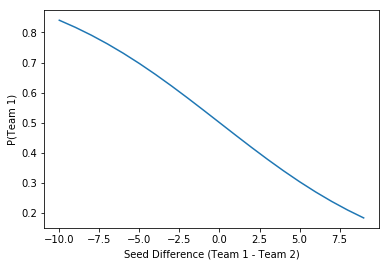

In [17]:
# visualize
x = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(x)[:,1];

plt.plot(x, preds);
plt.xlabel('Seed Difference (Team 1 - Team 2)');
plt.ylabel('P(Team 1)');

In [18]:
# AVERAGE RANK BASED LOGISTIC REGRESSION MODEL

In [19]:
df_massey = pd.read_csv('MasseyOrdinals.csv')

In [20]:
df_massey.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [21]:
# Create composite final rankings
final_day = 133
df_final_rankings = df_massey.loc[df_massey['RankingDayNum'] == final_day]
df_final_rankings = df_final_rankings.groupby(['Season', 'TeamID'])['OrdinalRank'].mean()
df_final_rankings = df_final_rankings.reset_index()
df_final_rankings.rename(columns={'OrdinalRank':'Avg. Rank'}, inplace=True)

In [22]:
df_final_rankings.head()

,Season,TeamID,Avg. Rank
0,2003,1102,156.03125
1,2003,1103,168.00000
2,2003,1104,38.03125
3,2003,1105,308.96875
4,2003,1106,262.68750


In [23]:
df_tour = pd.read_csv('NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [24]:
# Join tournament results
df_win_ranks = df_final_rankings.rename(columns={'TeamID':'WTeamID', 'Avg. Rank':'WAvgRank'})
df_loss_ranks = df_final_rankings.rename(columns={'TeamID':'LTeamID', 'Avg. Rank':'LAvgRank'})
df_dummy = pd.merge(left=df_tour, right=df_win_ranks, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=['Season', 'LTeamID'])
df_concat['ScoreDiff'] = df_concat['WScore'] - df_concat['LScore']
df_concat['RankDiff'] = df_concat['WAvgRank'] - df_concat['LAvgRank']
df_total = df_concat[['Season', 'DayNum', 'WTeamID','LTeamID', 'WAvgRank', 'LAvgRank', 'RankDiff']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDiff
0,2003,134,1421,1411,240.343750,239.281250,1.062500
1,2003,136,1112,1436,2.676471,153.125000,-150.448529
2,2003,136,1113,1272,36.000000,21.705882,14.294118
3,2003,136,1141,1166,45.687500,20.735294,24.952206
4,2003,136,1143,1301,36.406250,50.312500,-13.906250


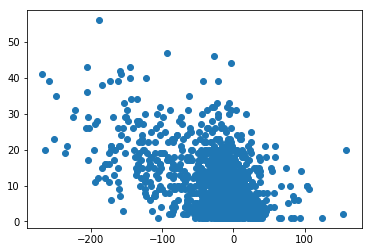

In [25]:
# Is ranking difference correlated with score difference?
plt.scatter(df_concat['RankDiff'], df_concat['ScoreDiff']);

In [26]:
# Create testing and training sets
df_wins = pd.DataFrame()
df_wins['RankDiff'] = df_total['RankDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['RankDiff'] = -df_total['RankDiff']
df_losses['Result'] = 0

In [27]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,RankDiff,Result
0,1.062500,1
1,-150.448529,1
2,14.294118,1
3,24.952206,1
4,-13.906250,1


In [28]:
x_train = df_predictions['RankDiff'].values.reshape(-1,1)
y_train = df_predictions['Result'].values
x_train, y_train = shuffle(x_train, y_train)

In [29]:
# Fit and test model
logreg2 = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(x_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5498, with best C: 0.0016681005372000592


In [30]:
# Store model results
df_results = df_results.append(pd.DataFrame({'Type': ['Avg. Ranking Based Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.555053
0,Avg. Ranking Based Logistic Regression,-0.549830


In [31]:
# FIVETHIRTHYEIGHT ELO LOGISTIIC REGRESSION #

In [32]:
# homecourt bonus
home_advantage=100
# learning rate
K=20

In [33]:
# load the regular season data
rs = pd.read_csv('RegularSeasonCompactResults.csv')
rs.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [34]:
# get total number of teams
team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
len(team_ids)

364

In [35]:
# score the lookup dict
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [36]:
# new columns to iteratively update ELOs
rs['margin']=rs.WScore-rs.LScore
rs['w_elo']=None
rs['l_elo']=None

In [37]:
# calculate the ELOs
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [38]:
# check order
assert np.all(rs.index.values == np.array(range(rs.shape[0]))), 'Index is out of order.'

In [39]:
# iterate through all the games
preds = []
for i in range(rs.shape[0]):
    
    # Get key data from current row
    w = rs.at[i, 'WTeamID']
    l = rs.at[i, 'LTeamID']
    margin = rs.at[i, 'margin']
    wloc = rs.at[i, 'WLoc']
    
    # does either team get a homecourt advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += home_advantage
    elif wloc == "A":
        l_ad += home_advantage
        
    # get ELO update as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    preds.append(pred)
    
    # Stores new ELOs in the games dataframe
    rs.loc[i, 'w_elo'] = elo_dict[w]
    rs.loc[i, 'l_elo'] = elo_dict[l]

In [40]:
# define the end-of-season ELOs
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [41]:
df_list = [final_elo_per_season(rs, i) for i in team_ids]
season_elos = pd.concat(df_list)

In [42]:
season_elos.head()

,team_id,season,season_elo
134286,1101,2014,1330.43
139681,1101,2015,1215.48
145038,1101,2016,1222.17
150369,1101,2017,1238.54
155760,1101,2018,1295.42


In [43]:
# Logistic Regression
df_tour = pd.read_csv('NCAATourneyCompactResults.csv')
df_tour.drop(labels=['DayNum','WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)

df_win_elos = season_elos.rename(columns={'team_id':'WTeamID', 'season':'Season', 'season_elo':'W_Elo'}) #
df_loss_elos = season_elos.rename(columns={'team_id':'LTeamID', 'season':'Season', 'season_elo':'L_Elo'}) #
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Elo_Diff'] = df_concat['W_Elo'] - df_concat['L_Elo']
df_concat.head()

,Season,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,1116,1234,1584.84,1605.27,-20.4313
1,1985,1120,1345,1565.57,1575.53,-9.96109
2,1985,1207,1250,1730.94,1434.15,296.784
3,1985,1229,1425,1577.5,1573.09,4.40622
4,1985,1242,1325,1608.69,1593.85,14.8439


In [44]:
# prediction dataframe
df_wins = pd.DataFrame()
df_wins['Elo_Diff'] = df_concat['Elo_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Elo_Diff'] = -df_concat['Elo_Diff']
df_losses['Result'] = 0

In [45]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Elo_Diff,Result
0,-20.4313,1
1,-9.96109,1
2,296.784,1
3,4.40622,1
4,14.8439,1


In [46]:
x_train = df_predictions['Elo_Diff'].values.reshape(-1,1)
y_train = df_predictions['Result'].values
x_train, y_train = shuffle(x_train, y_train)

In [47]:
# fit and test model
logreg2 = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(x_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5462, with best C: 0.0016681005372000592


In [48]:
# store model results
df_results = df_results.append(pd.DataFrame({'Type': ['FiveThirtyEight Elo Logistic Regression'],
                                            'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.555053
0,Avg. Ranking Based Logistic Regression,-0.549830
0,FiveThirtyEight Elo Logistic Regression,-0.546213


In [49]:
# SELECT RANKING SYSTEMS #

In [50]:
df_tour = pd.read_csv('NCAATourneyCompactResults.csv')
df_tour.drop(labels=['DayNum','WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [51]:
# Get list of all ranking systems
ranking_types = df_massey['SystemName'].unique().tolist()
ranking_types = [e for e in ranking_types if e not in ('MIC', 'GC', 'RAG', 'TOL', 'EBB', 'BP5', 'MPI', 'BOW', 'CTL')]
print(ranking_types)

['SEL', 'AP', 'BIH', 'DUN', 'ENT', 'GRN', 'IMS', 'MAS', 'MKV', 'MOR', 'POM', 'RPI', 'SAG', 'SAU', 'SE', 'STR', 'USA', 'WLK', 'WOB', 'BOB', 'DWH', 'ERD', 'ECK', 'BRZ', 'ARG', 'RTH', 'WOL', 'HOL', 'COL', 'DOL', 'GRS', 'HER', 'TSR', 'WTE', 'BD', 'MGY', 'CNG', 'SIM', 'DES', 'JON', 'LYN', 'NOR', 'RM', 'REI', 'ACU', 'BCM', 'CMV', 'SAP', 'DC', 'KLK', 'WIL', 'ROH', 'RIS', 'REN', 'SCR', 'DOK', 'PIG', 'KPK', 'PKL', 'TRX', 'MB', 'JCI', 'PH', 'LYD', 'KRA', 'RTR', 'UCS', 'ISR', 'CPR', 'BKM', 'JEN', 'REW', 'STH', 'SPW', 'RSE', 'PGH', 'CPA', 'RTB', 'HKB', 'BPI', 'TW', 'NOL', 'DC2', 'DCI', 'OMY', 'LMC', 'RT', 'KEL', 'KMV', 'RTP', 'TMR', 'AUS', 'ROG', 'PTS', 'KOS', 'PEQ', 'ADE', 'BNM', 'CJB', 'BUR', 'HAT', 'MSX', 'BBT', '7OT', 'SFX', 'EBP', 'TBD', 'CRO', 'D1A', 'TPR', 'BLS', 'DII', 'KBM', 'TRP', 'LOG', 'SP', 'STF', 'WMR', 'PPR', 'STS', 'UPS', 'SPR', 'MvG', 'TRK', 'BWE', 'HAS', 'FSH', 'DAV', 'KPI', 'FAS', 'MCL', 'HRN', 'RSL', 'SMN', 'DDB', 'INP', 'JRT', 'ESR', 'FMG', 'PRR', 'SMS', 'HKS', 'MUZ', 'OCT', '

In [52]:
# Iterate through each ranking and check log loss
def logreg_type(mytype):
    df_type = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == mytype)]
    df_type = df_type.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_type.rename(columns={'OrdinalRank':'Type Rank'}, inplace=True)

    df_win_ranks = df_type.rename(columns={'TeamID':'WTeamID', 'Type Rank':'WTypeRank'})
    df_loss_ranks = df_type.rename(columns={'TeamID':'LTeamID', 'Type Rank':'LTypeRank'})
    df_dummy = pd.merge(left=df_tour, right=df_win_ranks, how='left', on=['Season', 'WTeamID'])
    df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=['Season', 'LTeamID'])
    df_concat['RankDiff'] = df_concat['WTypeRank'] - df_concat['LTypeRank']
    df_total = df_concat[['Season', 'WTeamID','LTeamID', 'WTypeRank', 'LTypeRank', 'RankDiff']]
    
    if len(df_total) > 980:
        df_wins = pd.DataFrame()
        df_wins['RankDiff'] = df_total['RankDiff']
        df_wins['Result'] = 1
        df_losses = pd.DataFrame()
        df_losses['RankDiff'] = -df_total['RankDiff']
        df_losses['Result'] = 0

        df_predictions = pd.concat((df_wins, df_losses))

        X_train = df_predictions['RankDiff'].values.reshape(-1,1)
        Y_train = df_predictions['Result'].values
        X_train, Y_train = shuffle(X_train, Y_train)
        if np.isnan(np.sum(X_train)) == False:

            logregtype = LogisticRegression()
            params = {'C': np.logspace(start=-5, stop=5, num=10)}
            clf = GridSearchCV(logregtype, params, scoring='neg_log_loss', refit=True)
            clf.fit(X_train, Y_train)

            print('{} - Best log_loss: {:.4}, with best C: {}'.format(mytype, clf.best_score_, clf.best_params_['C']))
            return(pd.DataFrame({'Type': [mytype], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
        return(pd.DataFrame({'Type': [mytype], 'Log Loss': [999]}, columns=['Type', 'Log Loss']))
    return(pd.DataFrame({'Type': [mytype], 'Log Loss': [999]}, columns=['Type', 'Log Loss']))

In [53]:
df_type_scores = pd.DataFrame(columns=['Type', 'Log Loss'])
for mytype in ranking_types:
    df_type_scores = df_type_scores.append(logreg_type(mytype))

BIH - Best log_loss: -0.562, with best C: 0.0001291549665014884
MOR - Best log_loss: -0.5535, with best C: 0.0016681005372000592
POM - Best log_loss: -0.5537, with best C: 0.0001291549665014884
RPI - Best log_loss: -0.5588, with best C: 0.0001291549665014884
SAG - Best log_loss: -0.5511, with best C: 0.0016681005372000592
WLK - Best log_loss: -0.5534, with best C: 0.0001291549665014884
WOB - Best log_loss: -0.5648, with best C: 0.0001291549665014884
RTH - Best log_loss: -0.558, with best C: 0.0001291549665014884
WOL - Best log_loss: -0.5587, with best C: 0.0016681005372000592
COL - Best log_loss: -0.5596, with best C: 0.0001291549665014884
DOL - Best log_loss: -0.558, with best C: 0.0001291549665014884
CNG - Best log_loss: -0.5581, with best C: 0.0016681005372000592


In [54]:
df_type_scores = df_type_scores.loc[df_type_scores['Log Loss'] != 999]
df_type_scores.sort_values(by='Log Loss', ascending=False, inplace=True)
df_type_scores

,Type,Log Loss
0,SAG,-0.551099
0,WLK,-0.553409
0,MOR,-0.553479
0,POM,-0.553655
0,DOL,-0.557957
0,RTH,-0.558048
0,CNG,-0.558137
0,WOL,-0.558682
0,RPI,-0.558786
0,COL,-0.559612


In [55]:
# FINAL MODEL SELECTION #
# have generated 3 different metric options to test, tune, and consider for use:

# 1. FiveThirtyEight Elo Ratings
# 2. Average Select Ranking Systems
# 3. Composite Model

In [56]:
# 1 # FIVETHIRTYEIGHT ELO RATINGS MODEL #

In [57]:
# How does Elo perform alone?
df_tour = pd.read_csv('NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)

df_win_elos = season_elos.rename(columns={'team_id':'WTeamID', 'season_elo':'W_Elo', 'season':'Season'})
df_loss_elos = season_elos.rename(columns={'team_id':'LTeamID', 'season_elo':'L_Elo', 'season':'Season'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Elo_Diff'] = df_concat['W_Elo'] - df_concat['L_Elo']
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,136,1116,1234,1584.84,1605.27,-20.4313
1,1985,136,1120,1345,1565.57,1575.53,-9.96109
2,1985,136,1207,1250,1730.94,1434.15,296.784
3,1985,136,1229,1425,1577.5,1573.09,4.40622
4,1985,136,1242,1325,1608.69,1593.85,14.8439


In [58]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['Elo_Diff'] = df_concat['Elo_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['Elo_Diff'] = -df_concat['Elo_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result
0,1985,136,1116,1234,-20.4313,1
1,1985,136,1120,1345,-9.96109,1
2,1985,136,1207,1250,296.784,1
3,1985,136,1229,1425,4.40622,1
4,1985,136,1242,1325,14.8439,1


In [59]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

4284

In [60]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

x_train = df_train['Elo_Diff'].values.reshape(-1,1)
y_train = df_train['Result'].values

x_test = df_test['Elo_Diff'].values.reshape(-1,1)
y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(x_train, y_train)
clf.score(x_train, y_train)

-0.5472800544877574

In [61]:
# 2014-2018 results
y_pred = clf.predict(x_test)
df_test['Elo_Pred'] = y_pred
df_test.tail()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result,Elo_Pred
2179,2018,146,1242,1181,15.4129,0,1
2180,2018,146,1437,1403,-255.303,0,0
2181,2018,152,1276,1260,-234.69,0,0
2182,2018,152,1437,1242,-92.5824,0,0
2183,2018,154,1437,1276,-137.675,0,0


In [62]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))

Confusion Matrix: 
[[228  87]
 [ 87 228]] 

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       315
           1       0.72      0.72      0.72       315

   micro avg       0.72      0.72      0.72       630
   macro avg       0.72      0.72      0.72       630
weighted avg       0.72      0.72      0.72       630



In [63]:
# 2 # AVERAGE SELECT RANKING SYSTEMS #

In [64]:
# Pull and average the top performing rankins from previous analysis:
# 1. WLK 
# 2. SAG
# 3. POM
# 4. MOR

In [65]:
# Pull various system rankings
df_topranks = season_elos.loc[:, season_elos.columns != 'Elo']
df_topranks = df_topranks.rename(columns={'team_id':'Team_ID', 'season':'Season'}) 

df_temp = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'WLK')]
df_temp = df_temp.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp.rename(columns={'OrdinalRank':'WLK', 'TeamID':'Team_ID'}, inplace=True)

df_temp2 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'SAG')]
df_temp2 = df_temp2.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp2.rename(columns={'OrdinalRank':'SAG', 'TeamID':'Team_ID'}, inplace=True)

df_temp3 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'POM')]
df_temp3 = df_temp3.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp3.rename(columns={'OrdinalRank':'POM', 'TeamID':'Team_ID'}, inplace=True)

df_temp4 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'MOR')]
df_temp4 = df_temp4.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp4.rename(columns={'OrdinalRank':'MOR', 'TeamID':'Team_ID'}, inplace=True)

df_topranks = pd.merge(left=df_topranks, right=df_temp, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp2, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp3, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp4, how='left', on=['Season', 'Team_ID'])

In [66]:
# Mean of all four systems
df_topranks['MeanRank'] = (df_topranks['WLK'] + df_topranks['SAG'] + df_topranks['POM'] + df_topranks['MOR']) / 4
df_topranks.dropna(inplace = True)
df_topranks.head()

,Team_ID,Season,season_elo,WLK,SAG,POM,MOR,MeanRank
0,1101,2014,1330.43,330.0,346.0,348.0,349.0,343.25
1,1101,2015,1215.48,332.0,336.0,332.0,346.0,336.50
2,1101,2016,1222.17,304.0,320.0,318.0,311.0,313.25
3,1101,2017,1238.54,307.0,305.0,300.0,317.0,307.25
4,1101,2018,1295.42,261.0,276.0,262.0,265.0,266.00


In [67]:
# Join with tournament dataframe
df_tour = pd.read_csv('NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df_topranks.drop(labels=['WLK', 'SAG', 'POM', 'MOR'], inplace=True, axis=1)

df_win_elos = df_topranks.rename(columns={'Team_ID':'WTeamID', 'MeanRank':'W_MeanRank'})
df_loss_elos = df_topranks.rename(columns={'Team_ID':'LTeamID', 'MeanRank':'L_MeanRank'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['MeanRank_Diff'] = df_concat['W_MeanRank'] - df_concat['L_MeanRank']
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,season_elo_x,W_MeanRank,season_elo_y,L_MeanRank,MeanRank_Diff
0,2003,134,1421,1411,1324.06,259.50,1292.11,264.50,-5.00
1,2003,136,1112,1436,2039.17,2.75,1444.91,160.50,-157.75
2,2003,136,1113,1272,1775.78,30.00,1822.85,22.00,8.00
3,2003,136,1141,1166,1647.44,45.00,1827.46,24.25,20.75
4,2003,136,1143,1301,1853.24,39.00,1818.38,44.00,-5.00


In [68]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['MeanRank_Diff'] = df_concat['MeanRank_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['MeanRank_Diff'] = -df_concat['MeanRank_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,MeanRank_Diff,Result
0,2003,134,1421,1411,-5.00,1
1,2003,136,1112,1436,-157.75,1
2,2003,136,1113,1272,8.00,1
3,2003,136,1141,1166,20.75,1
4,2003,136,1143,1301,-5.00,1


In [69]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

2016

In [70]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

x_train = df_train['MeanRank_Diff'].values.reshape(-1,1)
y_train = df_train['Result'].values

x_test = df_test['MeanRank_Diff'].values.reshape(-1,1)
y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf2 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf2.fit(x_train, y_train)
clf2.score(x_train, y_train)

-0.5450159995753735

In [71]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))

Confusion Matrix: 
[[228  87]
 [ 87 228]] 

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       315
           1       0.72      0.72      0.72       315

   micro avg       0.72      0.72      0.72       630
   macro avg       0.72      0.72      0.72       630
weighted avg       0.72      0.72      0.72       630



In [72]:
# COMPOSITE MODEL #
# Standardize the Elo ratings and rankings and take the mean for logistic regression

In [73]:
# Set up and drop null rows
season_elos = season_elos.rename(columns={'team_id':'Team_ID', 'season':'Season', 'season_elo':'Elo'}) 
df = pd.merge(left=season_elos, right=df_topranks, how='left', on=['Season', 'Team_ID'])
df.dropna(inplace=True)
df.head()

,Team_ID,Season,Elo,season_elo,MeanRank
0,1101,2014,1330.43,1330.43,343.25
1,1101,2015,1215.48,1215.48,336.50
2,1101,2016,1222.17,1222.17,313.25
3,1101,2017,1238.54,1238.54,307.25
4,1101,2018,1295.42,1295.42,266.00


In [74]:
# Normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))

In [75]:
# Model 1
df['Composite Score'] = (df['Elo_Scaled'] + (2 * df['MeanRank_Scaled'])) / 3
df.head()

# Model 2
#df['Composite Score'] = (df['Elo_Scaled'] + (df['MeanRank_Scaled'])) / 2
#df.head()

,Team_ID,Season,Elo,season_elo,MeanRank,Elo_Scaled,MeanRank_Scaled,Composite Score
0,1101,2014,1330.43,1330.43,343.25,0.382824,0.022143,0.142370
1,1101,2015,1215.48,1215.48,336.50,0.294247,0.041429,0.125701
2,1101,2016,1222.17,1222.17,313.25,0.299408,0.107857,0.171708
3,1101,2017,1238.54,1238.54,307.25,0.312018,0.125000,0.187339
4,1101,2018,1295.42,1295.42,266.00,0.355848,0.242857,0.280521


In [76]:
# Join tournament dataframe
df_tour = pd.read_csv('NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df.drop(labels=['Elo', 'season_elo', 'MeanRank'], inplace=True, axis=1)

df_win_elos = df.rename(columns={'Team_ID':'WTeamID', 'Composite Score':'W_Composite'})
df_loss_elos = df.rename(columns={'Team_ID':'LTeamID', 'Composite Score':'L_Composite'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Composite_Diff'] = df_concat['W_Composite'] - df_concat['L_Composite']
df_total = df_concat[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_Composite', 'L_Composite', 'Composite_Diff']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite,Composite_Diff
0,2003,134,1421,1411,0.300259,0.282528,0.017730
1,2003,136,1112,1436,0.972983,0.519869,0.453114
2,2003,136,1113,1272,0.853426,0.880755,-0.027329
3,2003,136,1141,1166,0.791889,0.877652,-0.085763
4,2003,136,1143,1301,0.856178,0.837702,0.018476


In [77]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['Composite_Diff'] = df_concat['Composite_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['Composite_Diff'] = -df_concat['Composite_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result
0,2003,134,1421,1411,0.017730,1
1,2003,136,1112,1436,0.453114,1
2,2003,136,1113,1272,-0.027329,1
3,2003,136,1141,1166,-0.085763,1
4,2003,136,1143,1301,0.018476,1


In [78]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

2016

In [79]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

x_train = df_train['Composite_Diff'].values.reshape(-1,1)
y_train = df_train['Result'].values

x_test = df_test['Composite_Diff'].values.reshape(-1,1)
y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf3

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 1.29155e-04, 1.66810e-03, 2.15443e-02, 2.78256e-01,
       3.59381e+00, 4.64159e+01, 5.99484e+02, 7.74264e+03, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [80]:
# Training score
clf3.fit(x_train, y_train)
clf3.score(x_train, y_train)

-0.5425788710173226

In [81]:
# Save model
filename = 'ncaa_tourney1.pkl'
#filename = 'ncaa_tourney2.pkl'
pickle.dump(clf3, open(filename, 'wb'))

In [82]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred))

Confusion Matrix: 
[[228  87]
 [ 87 228]] 

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       315
           1       0.72      0.72      0.72       315

   micro avg       0.72      0.72      0.72       630
   macro avg       0.72      0.72      0.72       630
weighted avg       0.72      0.72      0.72       630



In [83]:
# Model Performance

In [84]:
# 2014-2018 log loss
Y_pred = clf3.predict(x_test)
df_test['Pred'] = y_pred
clf3.score(x_test, y_test)

-0.5303873612914152

In [85]:
# Probabilities
probs = clf3.predict_proba(x_test)
y_prob = [max(item[0],item[1]) for item in probs]
df_test['Prob'] = y_prob

df_test.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result,Pred,Prob
717,2014,136,1163,1386,0.085557,1,1,0.677183
718,2014,136,1173,1326,-0.129780,1,0,0.754692
719,2014,136,1196,1107,0.490383,1,1,0.985885
720,2014,136,1217,1153,-0.063920,1,0,0.634946
721,2014,136,1257,1264,0.252727,1,1,0.899205


In [86]:
# Teams dataframe
teams = pd.read_csv('teams.csv')
teams.head()

df_dummy = teams.rename(columns={'TeamID':'WTeamID'})
df_results = pd.merge(left=df_test, right=df_dummy, how='left', on=['WTeamID'])

df_dummy = teams.rename(columns={'TeamID':'LTeamID'})
df_results = pd.merge(left=df_results, right=df_dummy, how='left', on=['LTeamID'])

df_results = df_results.rename(columns={'TeamName_x':'WTeamName', 'TeamName_y':'LTeamName'})
df_results = df_results[['Season', 'DayNum', 'WTeamName', 'LTeamName', 'Composite_Diff', 'Prob', 'Pred', 'Result']]
df_results.drop_duplicates(subset=['Season','DayNum','WTeamName'], keep='last', inplace=True)
df_results.head()

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
315,2014,136,Connecticut,St Joseph's PA,-0.085557,0.677183,0,0
316,2014,136,Dayton,Ohio St,0.129780,0.754692,1,0
317,2014,136,Florida,Albany NY,-0.490383,0.985885,0,0
318,2014,136,Harvard,Cincinnati,0.063920,0.634946,1,0
319,2014,136,Louisville,Manhattan,-0.252727,0.899205,0,0


In [87]:
# Wrong answers
incorrect = df_results.loc[df_results['Pred'] != df_results['Result']]
incorrect.sort_values(by='DayNum', ascending=False, inplace=True)
def get_incorrect_year(year):
    incorrect_year = incorrect.loc[incorrect['Season'] == year]
    return(incorrect_year)
get_incorrect_year(2018)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
625,2018,146,Kansas,Duke,0.012054,0.526071,1,0
623,2018,145,Loyola-Chicago,Kansas St,0.041171,0.588195,1,0
621,2018,144,Texas Tech,Purdue,0.051132,0.608917,1,0
617,2018,143,Loyola-Chicago,Nevada,0.058893,0.624799,1,0
616,2018,143,Kansas St,Kentucky,0.097417,0.699214,1,0
615,2018,143,Florida St,Gonzaga,0.094585,0.694030,1,0
608,2018,139,Florida St,Xavier,0.062682,0.632458,1,0
613,2018,139,Texas A&M,North Carolina,0.095975,0.696581,1,0
612,2018,139,Syracuse,Michigan St,0.130485,0.755820,1,0
610,2018,139,Nevada,Cincinnati,0.094923,0.694652,1,0


In [88]:
# First round 2018
def get_firstround_year(year):
    first_round = df_results.loc[(df_results['DayNum'] <= 137) & (df_results['Season'] == year)]    
    first_round.sort_values(by='Prob', ascending=False, inplace=True)
    return(first_round)
get_firstround_year(2018)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
598,2018,137,Xavier,TX Southern,-0.592112,0.994102,0,0
582,2018,136,Villanova,Radford,-0.509123,0.987974,0,0
596,2018,137,UMBC,Virginia,0.508641,0.987925,1,0
592,2018,137,North Carolina,Lipscomb,-0.445544,0.979327,0,0
593,2018,137,Purdue,CS Fullerton,-0.410343,0.972165,0,0
569,2018,136,Duke,Iona,-0.350983,0.954316,0,0
573,2018,136,Kansas,Penn,-0.319176,0.940689,0,0
580,2018,136,Tennessee,Wright St,-0.303599,0.932700,0,0
585,2018,137,Cincinnati,Georgia St,-0.294527,0.927599,0,0
581,2018,136,Texas Tech,SF Austin,-0.274696,0.915185,0,0


In [89]:
# Best composite scoring teams ever
df_dummy = teams.rename(columns={'TeamID':'Team_ID'})
df_scores = pd.merge(left=df, right=df_dummy, how='left', on=['Team_ID'])
df_scores = df_scores[['Season', 'TeamName', 'Composite Score']]
df_scores.sort_values(by='Composite Score', ascending=False, inplace=True)
df_scores.head(20)

,Season,TeamName,Composite Score
3168,2009,North Carolina,0.999048
1174,2006,Duke,0.996136
3167,2008,North Carolina,0.995121
5072,2018,Villanova,0.994377
1172,2004,Duke,0.993283
5088,2018,Virginia,0.992687
2100,2011,Kansas,0.991847
5071,2017,Villanova,0.990320
2165,2015,Kentucky,0.988991
2099,2010,Kansas,0.987954


In [90]:
# STAGE 1 SUBMISSIONS

In [91]:
# Sample submission dataframe
sample = pd.read_csv('SampleSubmissionStage1.csv')
sample.head()

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5


In [139]:
# Pull relevant information from ID
sample['Season'] = sample.apply(lambda row: row['ID'][0:4], axis=1)
sample['Team_ID_Low'] = sample.apply(lambda row: row['ID'][5:9], axis=1)
sample['Team_ID_High'] = sample.apply(lambda row: row['ID'][10:14], axis=1)
sample.tail()

,ID,Pred,Season,Team_ID_Low,Team_ID_High
11385,2018_1452_1460,0.5,2018,1452,1460
11386,2018_1452_1462,0.5,2018,1452,1462
11387,2018_1455_1460,0.5,2018,1455,1460
11388,2018_1455_1462,0.5,2018,1455,1462
11389,2018_1460_1462,0.5,2018,1460,1462


In [93]:
# Merge composite scores
df['Season'] = df['Season'].astype(str)
df['Team_ID'] = df['Team_ID'].astype(str)

df_lows = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_Low'})
df_highs = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_High'})

df_dummy = pd.merge(left=sample, right=df_lows, how='left', on=['Season', 'Team_ID_Low'])
df_concat = pd.merge(left=df_dummy, right=df_highs, on=['Season', 'Team_ID_High'])
df_sample = df_concat.rename(columns={'Score_x':'Score_Low', 'Score_y':'Score_High'})
df_sample['Score_Diff'] = df_sample['Score_Low'] - df_sample['Score_High']
df_full = df_sample
df_sample = df_sample[['ID', 'Score_Low', 'Score_High', 'Score_Diff','Pred']]

In [94]:
# Probabilities
diffs = df_sample['Score_Diff'].values.reshape(-1,1)
probs = clf3.predict_proba(diffs)
Y_prob = [item[1] for item in probs]
df_sample['Pred'] = Y_prob
df_sample.head()

,ID,Score_Low,Score_High,Score_Diff,Pred
0,2014_1107_1110,0.490099,0.614172,-0.124074,0.254571
1,2014_1107_1112,0.490099,0.955868,-0.465769,0.017409
2,2014_1110_1112,0.614172,0.955868,-0.341696,0.049321
3,2014_1107_1113,0.490099,0.811401,-0.321302,0.058292
4,2014_1110_1113,0.614172,0.811401,-0.197229,0.153443


In [95]:
# Submission
df_submission = df_sample[['ID', 'Pred']]
df_submission.head()

,ID,Pred
0,2014_1107_1110,0.254571
1,2014_1107_1112,0.017409
2,2014_1110_1112,0.049321
3,2014_1107_1113,0.058292
4,2014_1110_1113,0.153443


In [96]:
# Write to csv
df_submission.to_csv('stage1_submission.csv', index=None)

In [97]:
# REFORMAT DATA #

In [98]:
season_elos = season_elos.rename(columns={'team_id':'Team_ID', 'season':'Season', 'season_elo':'Elo'}) 
df = pd.merge(left=season_elos, right=df_topranks, how='left', on=['Season', 'Team_ID'])
df.dropna(inplace=True)
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))
df['Composite Score'] = (df['Elo_Scaled'] + df['MeanRank_Scaled']) / 2

df_tour = pd.read_csv('NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df.drop(labels=['Elo', 'season_elo', 'MeanRank'], inplace=True, axis=1)

df_win_elos = df.rename(columns={'Team_ID':'WTeamID', 'Composite Score':'W_Composite'})
df_loss_elos = df.rename(columns={'Team_ID':'LTeamID', 'Composite Score':'L_Composite'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])

df_total = df_concat[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_Composite', 'L_Composite']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite
0,2003,134,1421,1411,0.319673,0.300221
1,2003,136,1112,1436,0.961975,0.507661
2,2003,136,1113,1272,0.821567,0.851132
3,2003,136,1141,1166,0.750691,0.849693
4,2003,136,1143,1301,0.838553,0.817982


In [99]:
df_total['TeamID_Upper'] = np.where(df_total['WTeamID'] >= df_total['LTeamID'], df_total['WTeamID'], df_total['LTeamID'])
df_total['TeamID_Lower'] = np.where(df_total['LTeamID'] >= df_total['WTeamID'], df_total['WTeamID'], df_total['LTeamID'])

df_total['Composite_Upper'] = np.where(df_total['W_Composite'] >= df_total['L_Composite'], df_total['W_Composite'], df_total['L_Composite'])
df_total['Composite_Lower'] = np.where(df_total['L_Composite'] >= df_total['W_Composite'], df_total['W_Composite'], df_total['L_Composite'])

df_total['Composite_Diff'] = df_total['Composite_Lower'] - df_total['Composite_Upper']
df_total = df_total[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'TeamID_Upper', 'TeamID_Lower', 'Composite_Upper', 'Composite_Lower', 'Composite_Diff']]

df_total.head()

,Season,DayNum,WTeamID,LTeamID,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff
0,2003,134,1421,1411,1421,1411,0.319673,0.300221,-0.019453
1,2003,136,1112,1436,1436,1112,0.961975,0.507661,-0.454313
2,2003,136,1113,1272,1272,1113,0.851132,0.821567,-0.029565
3,2003,136,1141,1166,1166,1141,0.849693,0.750691,-0.099001
4,2003,136,1143,1301,1301,1143,0.838553,0.817982,-0.020571


In [100]:
df_total['Result'] = np.where(df_total['WTeamID'] == df_total['TeamID_Lower'], 1, 0)
df_predictions = df_total.drop(['WTeamID', 'LTeamID'], axis=1)
df_predictions.head()

,Season,DayNum,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff,Result
0,2003,134,1421,1411,0.319673,0.300221,-0.019453,0
1,2003,136,1436,1112,0.961975,0.507661,-0.454313,1
2,2003,136,1272,1113,0.851132,0.821567,-0.029565,1
3,2003,136,1166,1141,0.849693,0.750691,-0.099001,1
4,2003,136,1301,1143,0.838553,0.817982,-0.020571,1


In [101]:
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

x_train = df_train['Composite_Diff'].values.reshape(-1,1)
y_train = df_train['Result'].values

x_test = df_test['Composite_Diff'].values.reshape(-1,1)
y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf3.fit(x_train, y_train)
clf3.score(x_train, y_train)

-0.6927828275404402

In [102]:
# SIMPLIFIED ELEMENTS FROM ABOVE #

In [268]:
def get_teams_df(year):
    
    # Get all teams for all seasons
    df = pd.read_csv('Prelim2019_RegularSeasonCompactResults.csv')

    df = df.loc[df['Season'] == year]
    team_ids = set(df.WTeamID).union(set(df.LTeamID))
    team_list = list(team_ids)
    teams = pd.DataFrame({'Team_ID':team_list})
    teams['Season'] = year
    teams = teams[['Season', 'Team_ID']]
    return(teams)

In [269]:
def get_team_name(id):
    
    # Get school name for a given team id in 2018
    teams = pd.read_csv('TeamsS2.csv')
    name = teams.loc[teams['TeamID'] == id]['TeamName']
    return(name.values[0])

In [270]:
def get_team_id(name):
    
    # Get school name for a given team id in 2018
    teams = pd.read_csv('TeamsS2.csv')
    id = teams.loc[teams['TeamName'] == name]['TeamID']
    return(id.values[0])

In [271]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin, K):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [272]:
def get_elos_df(year):
    
    # Data
    df = pd.read_csv('Prelim2019_RegularSeasonCompactResults.csv')
    
    # Constants
    HOME_ADVANTAGE = 100 
    K = 22
    rs = df.loc[df['Season'] == year]
    rs.reset_index(inplace = True)
    
    # Dictionary for lookups
    team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
    elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

    # Set up columns
    rs['margin'] = rs.WScore - rs.LScore
    rs['w_elo'] = None
    rs['l_elo'] = None
    
    # Iterate through regular season
    preds = []
    for i in range(rs.shape[0]):

        # Get key data from current row
        w = rs.at[i, 'WTeamID']
        l = rs.at[i, 'LTeamID']
        margin = rs.at[i, 'margin']
        wloc = rs.at[i, 'WLoc']

        # Does either team get a home-court advantage?
        w_ad, l_ad, = 0., 0.
        if wloc == "H":
            w_ad += HOME_ADVANTAGE
        elif wloc == "A":
            l_ad += HOME_ADVANTAGE

        # Get elo updates as a result of the game
        pred, update = elo_update(elo_dict[w] + w_ad,
                                  elo_dict[l] + l_ad, 
                                  margin, K)
        elo_dict[w] += update
        elo_dict[l] -= update
        preds.append(pred)

        # Stores new elos in the games dataframe
        rs.loc[i, 'w_elo'] = elo_dict[w]
        rs.loc[i, 'l_elo'] = elo_dict[l]
        
    # Create and return final elo dataframe
    df_list = [final_elo_per_season(rs, i) for i in team_ids]
    season_elos = pd.concat(df_list)
    season_elos.rename(columns={'season':'Season', 'team_id':'Team_ID', 'season_elo':'Elo'}, inplace = True)
    return(season_elos)

In [273]:
def get_elo_score(elos_df, year, team_id):
    
    # Return final elo for a team in a given year
    score = elos_df.loc[(elos_df['season'] == year) & (elos_df['team_id'] == team_id)]['season_elo']
    return(score)

In [308]:
def get_select_ranks_df(year, day):

    # Get select ranking scores dataframe
    df = pd.read_csv('MasseyOrdinals_thru_2019_day_128.csv')

    # Get final day
    df2 = pd.read_csv('MasseyOrdinals_2019_only_day_133_52systems.csv')
    df = df.append(df2)
    
    # Set up
    teams = get_teams_df(year)
    #df_massey = df.loc[df['Season'] == 2019]

    df_temp = df.loc[(df['RankingDayNum'] == day) & (df['SystemName'] == 'WLK')]
    df_temp = df_temp.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp.rename(columns={'OrdinalRank':'WLK', 'TeamID':'Team_ID'}, inplace=True)

    df_temp2 = df.loc[(df['RankingDayNum'] == day) & (df['SystemName'] == 'SAG')]
    df_temp2 = df_temp2.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp2.rename(columns={'OrdinalRank':'SAG', 'TeamID':'Team_ID'}, inplace=True)

    df_temp3 = df.loc[(df['RankingDayNum'] == day) & (df['SystemName'] == 'POM')]
    df_temp3 = df_temp3.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp3.rename(columns={'OrdinalRank':'POM', 'TeamID':'Team_ID'}, inplace=True)

    df_temp4 = df.loc[(df['RankingDayNum'] == day) & (df['SystemName'] == 'MOR')]
    df_temp4 = df_temp4.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp4.rename(columns={'OrdinalRank':'MOR', 'TeamID':'Team_ID'}, inplace=True)

    teams = pd.merge(left=teams, right=df_temp, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp2, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp3, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp4, how='left', on=['Season', 'Team_ID'])
    
    # Calculate mean score
    teams['MeanRank'] = (teams['SAG'] + teams['WLK'] + teams['POM'] + teams['MOR']) / 4
    teams.dropna(inplace = True)
    massey_df = teams
    return(massey_df)

In [299]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
5,1985,25,1218,79,1337,78,H,0
6,1985,25,1228,64,1226,44,N,0
7,1985,25,1242,58,1268,56,N,0
8,1985,25,1260,98,1133,80,H,0
9,1985,25,1305,97,1424,89,H,0


In [300]:
df_massey

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
5,2003,35,SEL,1107,249
6,2003,35,SEL,1108,228
7,2003,35,SEL,1110,204
8,2003,35,SEL,1111,183
9,2003,35,SEL,1112,26


In [301]:
def get_select_rank(massey_df, year, day, team_id):
    score = massey_df.loc[(massey_df['Season'] == year) & (massey_df['Team_ID'] == team_id)]['MeanRank']
    return(score)

In [302]:
def get_composite_scores_df(year):
    
    # Get dataframe with composite scores for all teams
    FINAL_DAY = 133
    df = get_teams_df(year)
    ranks = get_select_ranks_df(year, FINAL_DAY)
    season_elos = get_elos_df(year)

    df = pd.merge(left=df, right=season_elos, how='left', on=['Season', 'Team_ID'])
    df = pd.merge(left=df, right=ranks, how='left', on=['Season', 'Team_ID'])
    df = df[['Season', 'Team_ID', 'MeanRank', 'Elo']]

    # Normalize features
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
    df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))

    # Average rankings
    df['Composite Score'] = (df['Elo_Scaled'] + (2 * df['MeanRank_Scaled'])) / 3
    df = df[['Season', 'Team_ID', 'Composite Score']]
    final_scores = df
    return(final_scores)

In [303]:
def generate_probs(model, year):
    sample = pd.read_csv('SampleSubmissionDos.csv')

    sample['Season'] = sample.apply(lambda row: row['ID'][0:4], axis=1)
    sample['Team_ID_Low'] = sample.apply(lambda row: row['ID'][5:9], axis=1)
    sample['Team_ID_High'] = sample.apply(lambda row: row['ID'][10:14], axis=1)
    sample.head()

    df = get_composite_scores_df(year)
    df = final_scores
    df['Season'] = df['Season'].astype(str)
    df['Team_ID'] = df['Team_ID'].astype(str)

    df_lows = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_Low'})
    df_highs = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_High'})

    df_dummy = pd.merge(left=sample, right=df_lows, how='left', on=['Season', 'Team_ID_Low'])
    df_concat = pd.merge(left=df_dummy, right=df_highs, on=['Season', 'Team_ID_High'])
    df_sample = df_concat.rename(columns={'Score_x':'Score_Low', 'Score_y':'Score_High'})
    df_sample['Score_Diff'] = df_sample['Score_Low'] - df_sample['Score_High']
    df_full = df_sample
    df_sample = df_sample[['ID', 'Score_Low', 'Score_High', 'Score_Diff','Pred']]

    diffs = df_sample['Score_Diff'].values.reshape(-1,1)
    probs = model.predict_proba(diffs)
    Y_prob = [item[1] for item in probs]
    df_sample['Pred'] = Y_prob
    df_sample = df_sample[['ID', 'Pred']]
    return(df_sample)

In [304]:
# 2019 RESULTS EDA

In [306]:
# Import data
df = pd.read_csv('RegularSeasonCompactResultsS2.csv')
df.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
161547,2019,132,1153,69,1222,57,N,0
161548,2019,132,1209,73,1426,64,N,0
161549,2019,132,1277,65,1276,60,N,0
161550,2019,132,1387,55,1382,53,N,0
161551,2019,132,1463,97,1217,85,H,0


In [309]:
# Run composite score functions
final_scores = get_composite_scores_df(2019)
final_scores.head()

,Season,Team_ID,Composite Score
0,2019,1101,0.591397
1,2019,1102,0.355285
2,2019,1103,0.615285
3,2019,1104,0.726485
4,2019,1105,0.044393


In [310]:
# Pull team names and format data
final_teams = final_scores
pd.options.display.float_format = '{:.3f}'.format

final_teams['Team Name'] = None
for index, rows in final_teams.iterrows():
    final_teams['Team Name'][index] = get_team_name(final_teams['Team_ID'][index])

final_teams = final_teams[['Season', 'Team Name', 'Composite Score']]
final_teams.sort_values(by='Composite Score', ascending = False, inplace = True)

final_teams.reset_index(inplace = True, drop = True)
final_teams.index += 1

In [311]:
# Look at rankings
final_teams.head(25)

,Season,Team Name,Composite Score
1,2019,Gonzaga,0.997
2,2019,Virginia,0.989
3,2019,North Carolina,0.972
4,2019,Duke,0.959
5,2019,Michigan St,0.950
6,2019,Houston,0.942
7,2019,Kentucky,0.941
8,2019,Tennessee,0.940
9,2019,Texas Tech,0.939
10,2019,Wofford,0.930


In [ ]:
# SUBMISSION I

In [312]:
# Sample data
sample = pd.read_csv('SampleSubmissionDos.csv')
sample.head()

,ID,Pred
0,2019_1101_1113,0.500
1,2019_1101_1120,0.500
2,2019_1101_1124,0.500
3,2019_1101_1125,0.500
4,2019_1101_1133,0.500


In [314]:
# Get probability dataframe
mod1 = pickle.load(open('ncaa_tourney1.pkl', 'rb'))
pred = generate_probs(mod1, 2019)
pred.head()

,ID,Pred
0,2019_1101_1113,0.178
1,2019_1101_1120,0.069
2,2019_1113_1120,0.254
3,2019_1101_1124,0.144
4,2019_1113_1124,0.436


In [315]:
# Write to csv
pred.to_csv('stage2_submission1.csv', index=None)

In [316]:
# SUBMISSION II

In [317]:
# Get probability dataframe
mod2 = pickle.load(open('ncaa_tourney2.pkl', 'rb'))
pred = generate_probs(mod2, 2019)
pred.head()

FileNotFoundError: [Errno 2] No such file or directory: 'ncaa_tourney2.pkl'

In [ ]:
# Write to csv
pred.to_csv('stage2_submission2.csv', index=None)